In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from patsy import dmatrices
import pymc3 as pm

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [27]:
# NSW Data Files (Dehejia-Wahha Sample)
# http://users.nber.org/~rdehejia/data/nswdata2.html

cps = pd.read_csv('data/lalonde/cps_controls.txt', delimiter='  ', names=[
        'treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr',
        're74', 're75', 're78'
    ])

original_treatment = pd.read_csv('data/lalonde/nswre74_treated.txt', delimiter='  ', names=[
        'treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr',
        're74', 're75', 're78'        
    ])

unmatched_raw = pd.concat([
        cps, original_treatment
    ], axis=0)

unmatched_raw['u74'] = (unmatched_raw.re74 == 0).astype(np.int32)
unmatched_raw['u75'] = (unmatched_raw.re75 == 0).astype(np.int32)

unmatched_raw[['re74_div', 're75_div', 're78_div']] = unmatched_raw[['re74', 're75', 're78']] / 1000

unmatched_raw.shape

/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/ipykernel/__main__.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


(16177, 15)

In [5]:
unmatched_raw.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670,0,0
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080,0,0
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670,0,0
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670,0,0
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869,0,0


In [6]:
unmatched_raw.tail()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
180,1.0,33.0,12.0,1.0,0.0,1.0,0.0,20279.95,10941.35,15952.600,0,0
181,1.0,25.0,14.0,1.0,0.0,1.0,0.0,35040.07,11536.57,36646.950,0,0
182,1.0,35.0,9.0,1.0,0.0,1.0,1.0,13602.43,13830.64,12803.970,0,0
183,1.0,35.0,8.0,1.0,0.0,1.0,1.0,13732.07,17976.15,3786.628,0,0
184,1.0,33.0,11.0,1.0,0.0,1.0,1.0,14660.71,25142.24,4181.942,0,0


/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


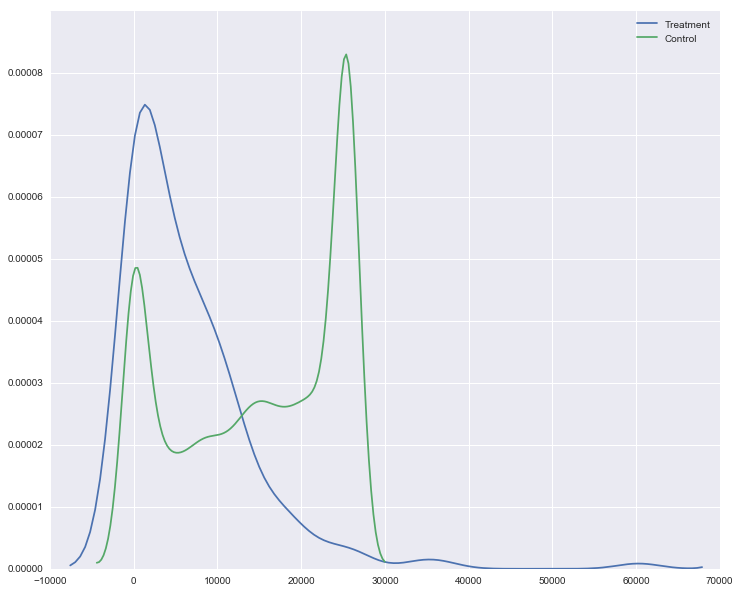

In [17]:
sns.kdeplot(unmatched_raw[unmatched_raw.treat == 1].re78, label='Treatment')
sns.kdeplot(unmatched_raw[unmatched_raw.treat == 0].re78, label='Control');

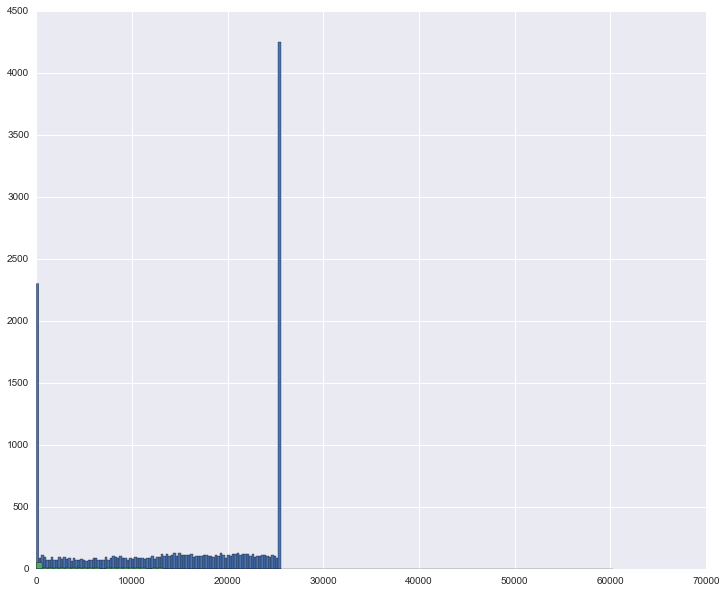

In [50]:
plt.hist(unmatched_raw[unmatched_raw.treat == 0].re78, label='Control', bins=100);
plt.hist(unmatched_raw[unmatched_raw.treat == 1].re78, label='Treatment', bins=100);

# Using the `causalinference` library

In [25]:
from causalinference import CausalModel

In [28]:
causal_model = CausalModel(
    X=unmatched_raw[['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74_div', 're75_div', 'u74', 'u75']].values, 
    D=unmatched_raw.treat.values,
    Y=unmatched_raw.re78_div.values
)
causal_model.est_propensity()
causal_model.trim_s()
causal_model.stratify_s()
causal_model.est_via_ols()
causal_model.est_via_matching(bias_adj=True)
causal_model.est_via_weighting()
print(causal_model.summary_stats)
print(causal_model.estimates)
print(causal_model.propensity)
print(causal_model.strata)


Summary Statistics

                       Controls (N_c=373)         Treated (N_t=149)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        4.814        6.084        6.038        8.006        1.224

                       Controls (N_c=373)         Treated (N_t=149)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       26.416       11.046       25.765        7.355       -0.069
             X1       10.595        2.698       10.221        2.066       -0.156
             X2        0.882        0.323        0.973        0.162        0.357
             X3        0.118        0.323        0.027        0.162       -0.357
             X4        0.214        0.411        0.134        0.342       -0.212
      

## Using our own Bayesian Model

For $y \in \mathbb{R}$, and $\mathbf{x} \in \mathbb{R}^M$

For $N$ data points, we have $(\mathbf{X}, \mathbf{y}) = \{(\mathbf{x}_n, y_n)\}$.

With the following distributions

$$
\begin{align*}
p(\mathbf{w}) &= \mathcal{N}(\mathbf{w} | 0, \sigma_w^2 \mathbf{I}) \\
p(b) &= \mathcal{N}(b | 0, \sigma_b^2) \\
p(\mathbf{y} | \mathbf{w}, b, \mathbf{X}) &= \prod_{n=1}^N \mathcal{N} (y_n | \mathbf{x}_n^{\intercal} \mathbf{w} + b, \sigma_y^2)
\end{align*}
$$

## Propensity Matching

In [62]:
propensity_formula = "treat ~ age + educ + black + hisp + married + nodegr + u74 + u75 + re75_div + re74_div + I(re74_div*re75_div)"

In [63]:
propensity_model = smf.glm(formula=propensity_formula, data=unmatched_raw, family=sm.families.Binomial()).fit()
propensity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  treat   No. Observations:                16177
Model:                            GLM   Df Residuals:                    16165
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -473.41
Date:                Sat, 19 Nov 2016   Deviance:                       946.82
Time:                        01:12:03   Pearson chi2:                 8.10e+03
No. Iterations:                    14                                         
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -6.6364      0.825     -8.045      0.000        -8.253    -5.020
age                       -0.0191      0.011     -1.788      0.074        -0.040     0.002
educ                       0.0195      0.048      0.404      0.686        -0.075     0.114
black                      4.2899      0.263     16.329      0.000         3.775     4.805
hisp                       1.8322      0.394      4.655      0.000         1.061     2.604
married                   -0.9954      0.240     -4.147      0.000        -1.466    -0.525
nodegr                     0.9100      0.274      3.318      0.001         0.372     1.448
u74                        1.7318      0.280      6.178      0.000         1.182     2.281
u75                        0.3934      0.253      1.555      0.120        -0.102     0.889
re75_div                  -0.0871      0.056     -1.559      0.119        -0.197     0.022
re74_div                   0.0985      0.033      2.968      0.003         0.033     0.164
I(re74_div * re75_div)    -0.0072      0.004     -1.800      0.072        -0.015     0.001
==========================================================================================
"""

In [64]:
_, X_propensity = dmatrices(propensity_formula, unmatched_raw, return_type='dataframe')

In [11]:
propensities = propensity_model.predict(exog=X_propensity)

In [12]:
(propensities < 0.5).sum()

16069

In [13]:
(propensities > 0.5).sum()

108

In [18]:
unmatched_raw.iloc[propensities > 0.5].treat.sum()

59.0

In [19]:
split = cps.shape[0]

In [239]:
propensities

array([  1.14167739e-05,   8.28539725e-04,   4.84711281e-06, ...,
         1.54944295e-02,   7.06815725e-03,   1.90132316e-03])

In [113]:
treatment = np.expand_dims(propensities[split:], 1)
control = np.expand_dims(propensities[:split], 1)

treatment.shape, control.shape

((185, 1), (15992, 1))

In [114]:
distances = cdist(treatment, control)

In [117]:
distances.shape

(185, 15992)

In [22]:
treatment_idx, control_idx = linear_sum_assignment(distances)
treatment_idx, control_idx

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [51]:
treatment_data = unmatched_raw[split:].iloc[treatment_idx]
control_data = unmatched_raw[:split].iloc[control_idx]
print(treatment_data.head())
print('----')
print(control_data.head())

   treat   age  educ  black  hisp  married  nodegr  re74  re75        re78  \
0    1.0  37.0  11.0    1.0   0.0      1.0     1.0   0.0   0.0   9930.0460   
1    1.0  22.0   9.0    0.0   1.0      0.0     1.0   0.0   0.0   3595.8940   
2    1.0  30.0  12.0    1.0   0.0      0.0     0.0   0.0   0.0  24909.4500   
3    1.0  27.0  11.0    1.0   0.0      0.0     1.0   0.0   0.0   7506.1460   
4    1.0  33.0   8.0    1.0   0.0      0.0     1.0   0.0   0.0    289.7899   

   u74  u75  re74_div  re75_div   re78_div  
0    1    1       0.0       0.0   9.930046  
1    1    1       0.0       0.0   3.595894  
2    1    1       0.0       0.0  24.909450  
3    1    1       0.0       0.0   7.506146  
4    1    1       0.0       0.0   0.289790  
----
       treat   age  educ  black  hisp  married  nodegr      re74       re75  \
4521     0.0  25.0  16.0    1.0   0.0      0.0     0.0     0.000  2023.0650   
6044     0.0  21.0  12.0    1.0   0.0      0.0     0.0  7012.216  1389.2900   
12316    0.0  44.0 

/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


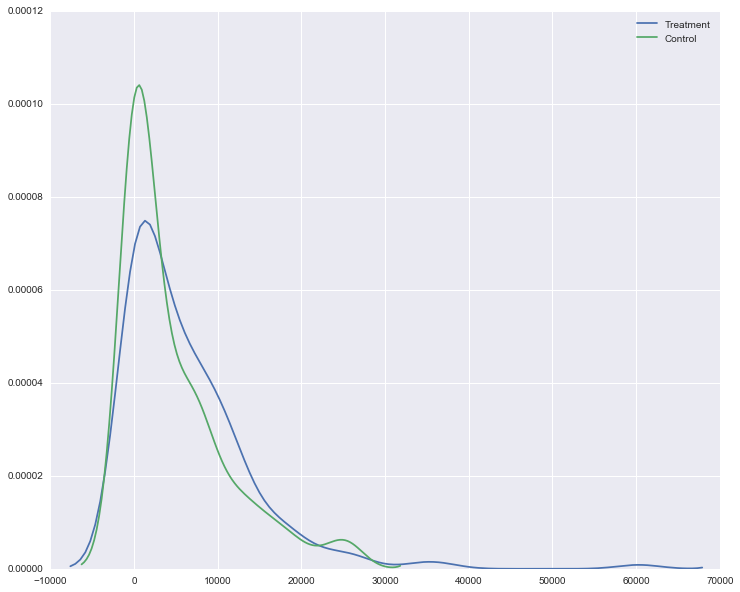

In [52]:
sns.kdeplot(treatment_data.re78, label='Treatment')
sns.kdeplot(control_data.re78, label='Control')

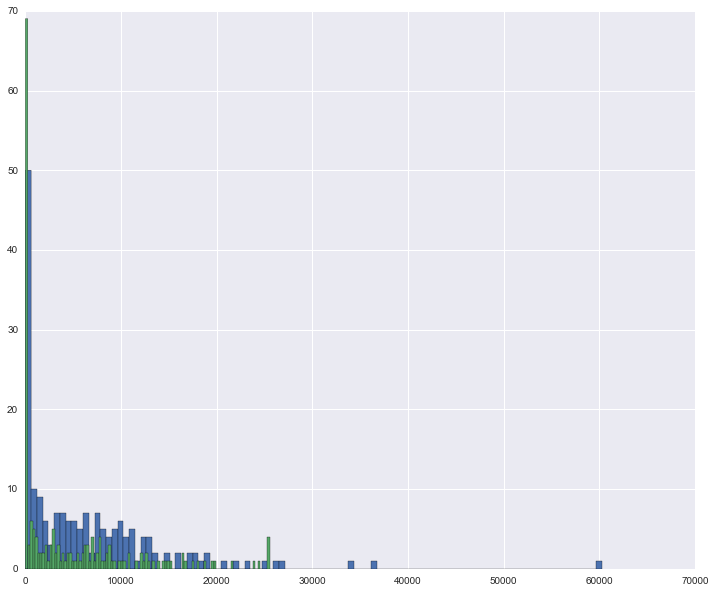

In [53]:
plt.hist(treatment_data.re78, label='Treatment', bins=100)
plt.hist(control_data.re78, label='Control', bins=100);

In [32]:
data_propensity_matched = pd.concat([
        treatment_data,
        control_data
        ], axis=0)
data_propensity_matched.shape

(370, 15)

In [41]:
causal_formula = "re78_div ~ treat + age + educ + black + hisp + married + nodegr + u74 + u75 + re74_div + re75_div"

Applied log-transform to sd and added transformed sd_log_ to model.
INFO:pymc3:Applied log-transform to sd and added transformed sd_log_ to model.


ADVI
Iteration 0 [0%]: ELBO = -88211.67
Iteration 8000 [10%]: Average ELBO = -172027.52
Iteration 16000 [20%]: Average ELBO = -1652.85
Iteration 24000 [30%]: Average ELBO = -1434.61
Iteration 32000 [40%]: Average ELBO = -1425.31
Iteration 40000 [50%]: Average ELBO = -1424.42
Iteration 48000 [60%]: Average ELBO = -1424.03
Iteration 56000 [70%]: Average ELBO = -1423.92
Iteration 64000 [80%]: Average ELBO = -1423.9
Iteration 72000 [90%]: Average ELBO = -1423.84
Finished [100%]: Average ELBO = -1423.67
Sampling


100%|██████████| 2000/2000 [00:21<00:00, 94.10it/s]


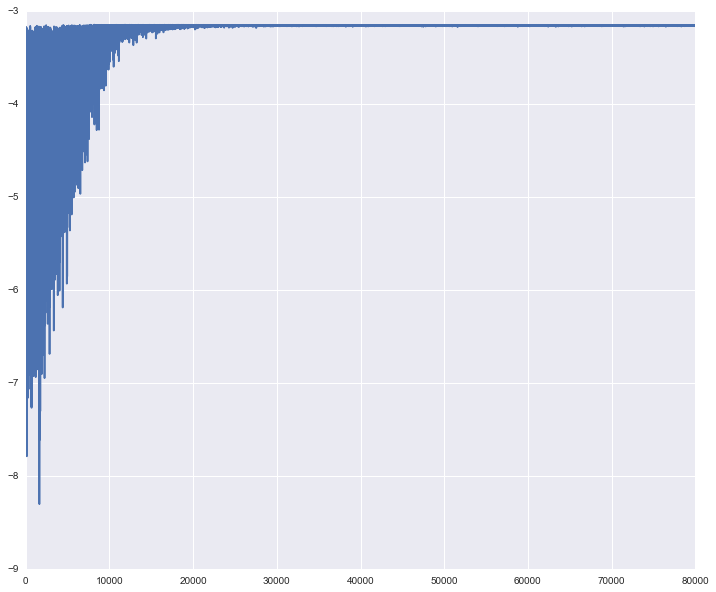

In [42]:
with pm.Model() as model:
    pm.glm.glm(causal_formula, data_propensity_matched)

    print('ADVI')
    propensity_v_params = pm.variational.advi(n=80000)
    plt.plot(-np.log10(-propensity_v_params.elbo_vals))

    print('Sampling')
    propensity_samples = pm.sample(
        2000, 
        step=pm.NUTS(scaling=propensity_v_params.means),
        start=propensity_v_params.means, 
        progressbar=True,
        njobs=3
    )

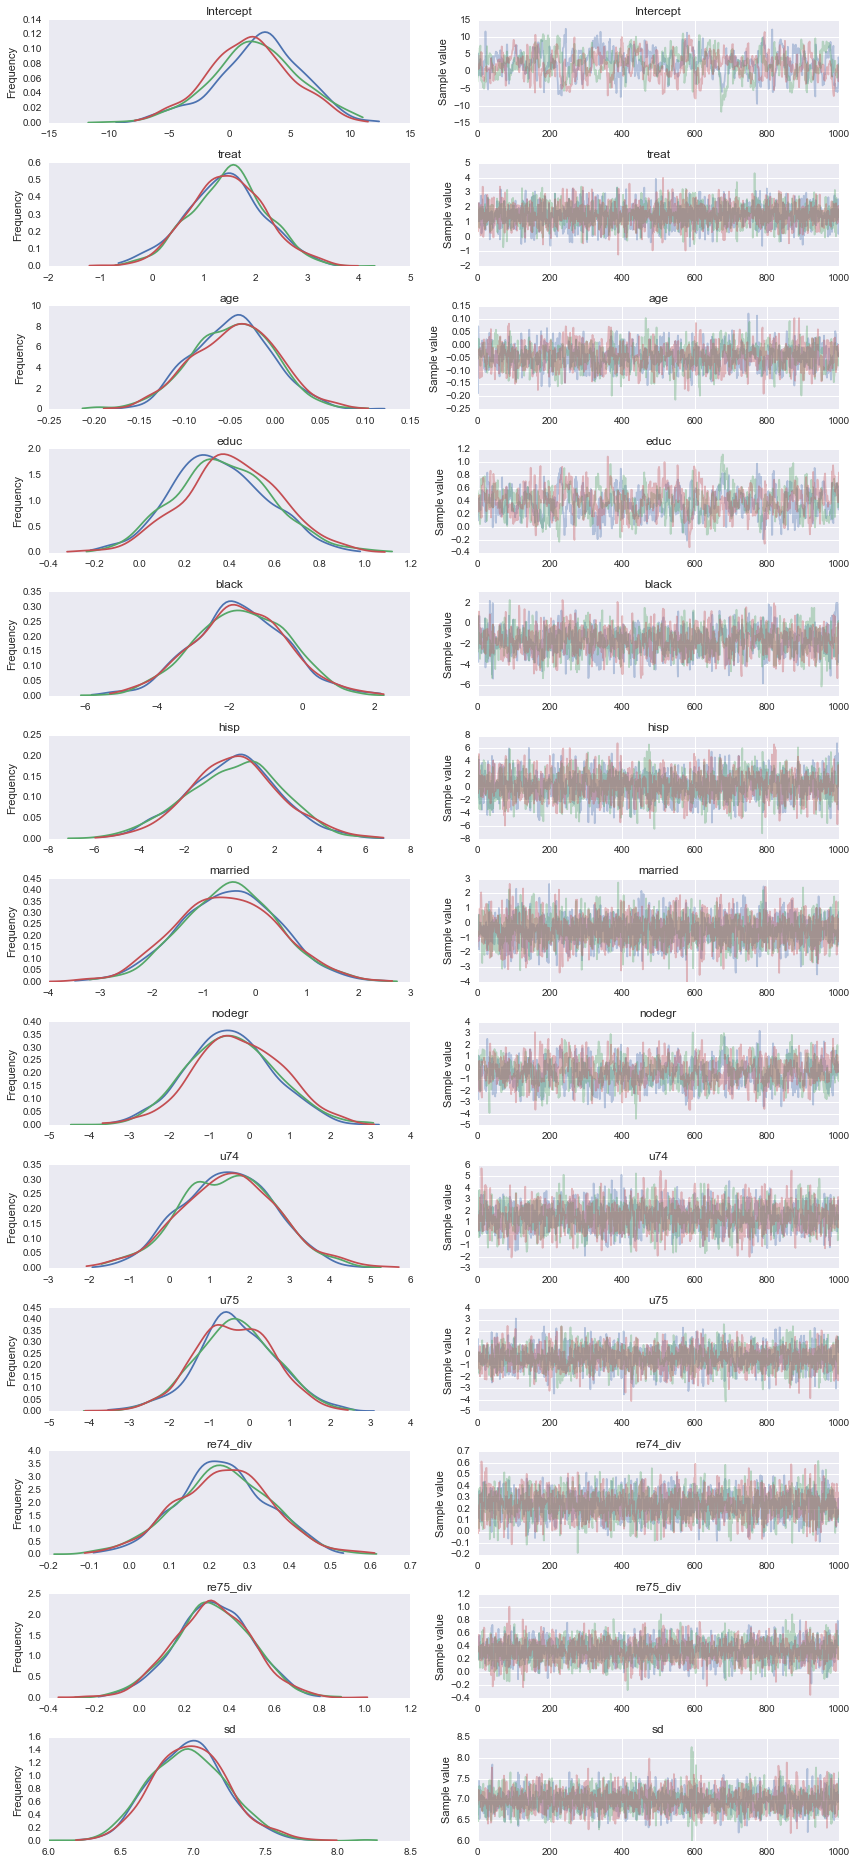

In [166]:
pm.traceplot(propensity_samples[1000:]);

In [44]:
df_propensity_samples = pm.trace_to_dataframe(propensity_samples[1000:])
df_propensity_samples.mean(0)

educ         0.379365
sd           6.975061
age         -0.045605
re74_div     0.234163
u75         -0.348949
hisp         0.212074
black       -1.702708
married     -0.502915
re75_div     0.326220
Intercept    2.110093
treat        1.455809
u74          1.479578
nodegr      -0.393994
dtype: float64

In [46]:
(df_propensity_samples['treat'] > 0).mean()

0.97233333333333338

## Mahalanobis Distance Matching

In [120]:
treatment = X_propensity[split:]
control = X_propensity[:split]

treatment.shape, control.shape

((185, 12), (15992, 12))

In [153]:
VI = np.diag(X_propensity.var())

In [155]:
distances = cdist(treatment, control, 'mahalanobis', VI=VI)

In [138]:
distances.shape

(185, 15992)

In [156]:
distances

array([[ 135182.83510144,    4629.92585063,  144100.509151  , ...,
            673.31701397,   47926.4099961 ,   44585.87728064],
       [ 135183.04471441,    4626.58455289,  144100.61715248, ...,
            693.41719141,   47927.07679146,   44586.3075516 ],
       [ 135182.90766673,    4627.61883146,  144100.53574859, ...,
            677.72824829,   47926.65059974,   44586.00185903],
       ..., 
       [  88360.21911782,   42196.73277318,   97277.86339938, ...,
          46149.73156054,    1112.10744682,    2237.57752433],
       [  73745.95007714,   56810.93390543,   82663.58549857, ...,
          60764.00520928,   13511.5796488 ,   16851.29273563],
       [  43443.74345557,   87113.18102854,   52361.28752152, ...,
          91066.3650603 ,   43813.5280718 ,   47153.64447944]])

In [157]:
treatment_idx, control_idx = linear_sum_assignment(distances)
treatment_idx, control_idx

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [158]:
treatment_data = unmatched_raw[split:].iloc[treatment_idx]
control_data = unmatched_raw[:split].iloc[control_idx]
print(treatment_data.head())
print('----')
print(control_data.head())

   treat   age  educ  black  hisp  married  nodegr  re74  re75        re78  \
0    1.0  37.0  11.0    1.0   0.0      1.0     1.0   0.0   0.0   9930.0460   
1    1.0  22.0   9.0    0.0   1.0      0.0     1.0   0.0   0.0   3595.8940   
2    1.0  30.0  12.0    1.0   0.0      0.0     0.0   0.0   0.0  24909.4500   
3    1.0  27.0  11.0    1.0   0.0      0.0     1.0   0.0   0.0   7506.1460   
4    1.0  33.0   8.0    1.0   0.0      0.0     1.0   0.0   0.0    289.7899   

   u74  u75  re74_div  re75_div   re78_div  
0    1    1       0.0       0.0   9.930046  
1    1    1       0.0       0.0   3.595894  
2    1    1       0.0       0.0  24.909450  
3    1    1       0.0       0.0   7.506146  
4    1    1       0.0       0.0   0.289790  
----
       treat   age  educ  black  hisp  married  nodegr  re74  re75      re78  \
5986     0.0  37.0  10.0    0.0   0.0      1.0     1.0   0.0   0.0     0.000   
10767    0.0  22.0   9.0    0.0   0.0      1.0     1.0   0.0   0.0     0.000   
1658     0.0  30

/Users/penglish/.virtualenvs/data3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


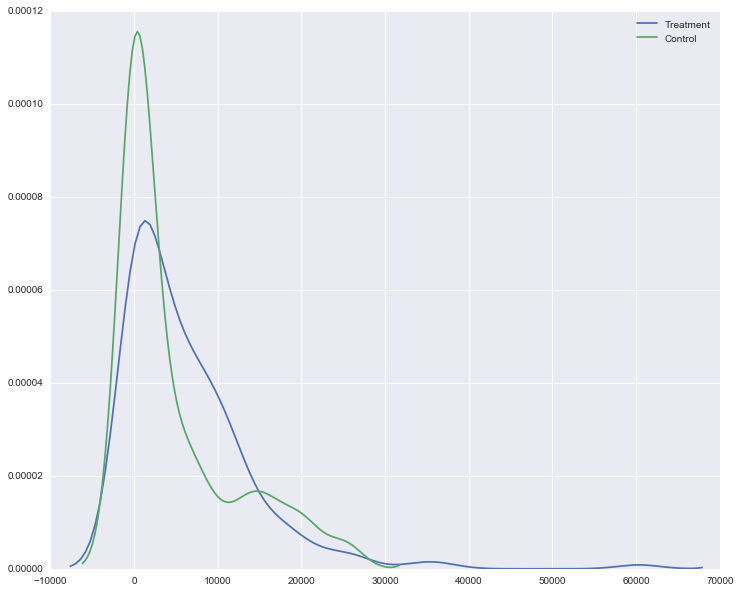

In [159]:
sns.kdeplot(treatment_data.re78, label='Treatment')
sns.kdeplot(control_data.re78, label='Control')

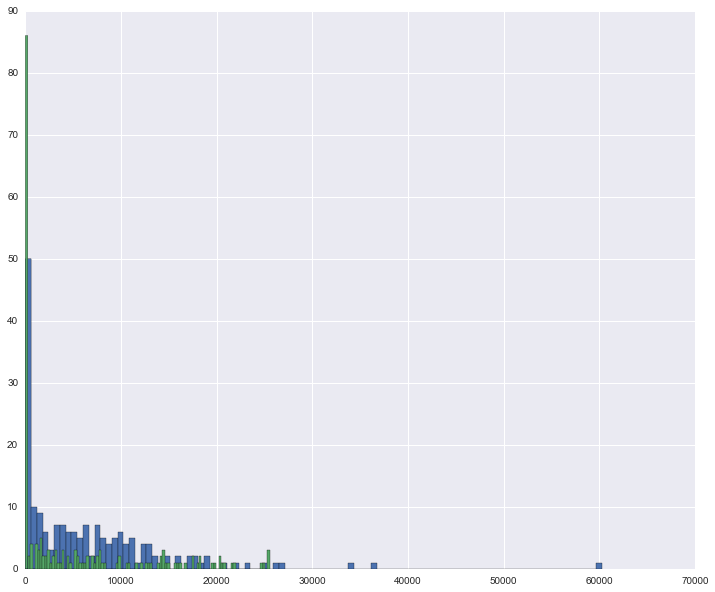

In [160]:
plt.hist(treatment_data.re78, label='Treatment', bins=100)
plt.hist(control_data.re78, label='Control', bins=100);

In [161]:
data_mahalanobis_matched = pd.concat([
        treatment_data,
        control_data
        ], axis=0)
data_mahalanobis_matched.shape

(370, 15)

Applied log-transform to sd and added transformed sd_log_ to model.
INFO:pymc3:Applied log-transform to sd and added transformed sd_log_ to model.


ADVI
Iteration 0 [0%]: ELBO = -4981.65
Iteration 8000 [10%]: Average ELBO = -139474.88
Iteration 16000 [20%]: Average ELBO = -1651.1
Iteration 24000 [30%]: Average ELBO = -1434.38
Iteration 32000 [40%]: Average ELBO = -1425.33
Iteration 40000 [50%]: Average ELBO = -1424.42
Iteration 48000 [60%]: Average ELBO = -1424.1
Iteration 56000 [70%]: Average ELBO = -1423.94
Iteration 64000 [80%]: Average ELBO = -1423.77
Iteration 72000 [90%]: Average ELBO = -1423.84
Finished [100%]: Average ELBO = -1423.84
Sampling


100%|██████████| 2000/2000 [00:26<00:00, 83.62it/s]


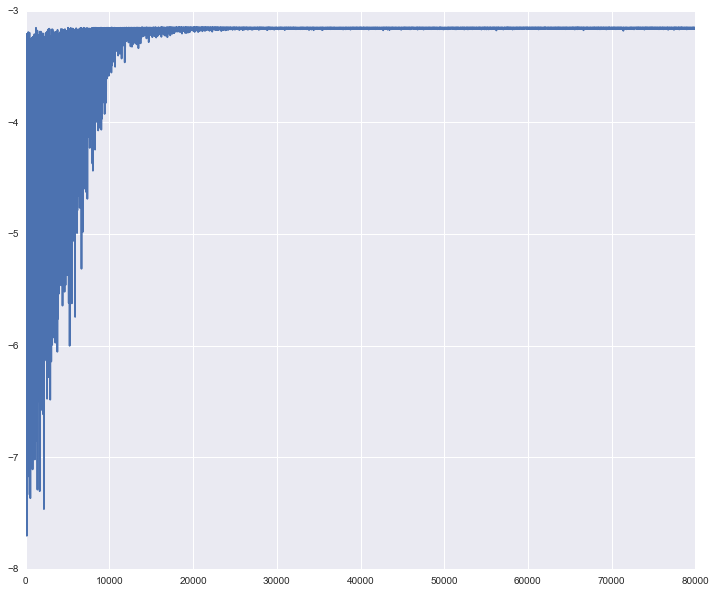

In [162]:
with pm.Model() as model:
    pm.glm.glm(causal_formula, data_propensity_matched)

    print('ADVI')
    mahalanobis_v_params = pm.variational.advi(n=80000)
    plt.plot(-np.log10(-mahalanobis_v_params.elbo_vals))

    print('Sampling')
    mahalanobis_samples = pm.sample(
        2000, 
        step=pm.NUTS(scaling=mahalanobis_v_params.means),
        start=mahalanobis_v_params.means, 
        progressbar=True,
        njobs=4
    )

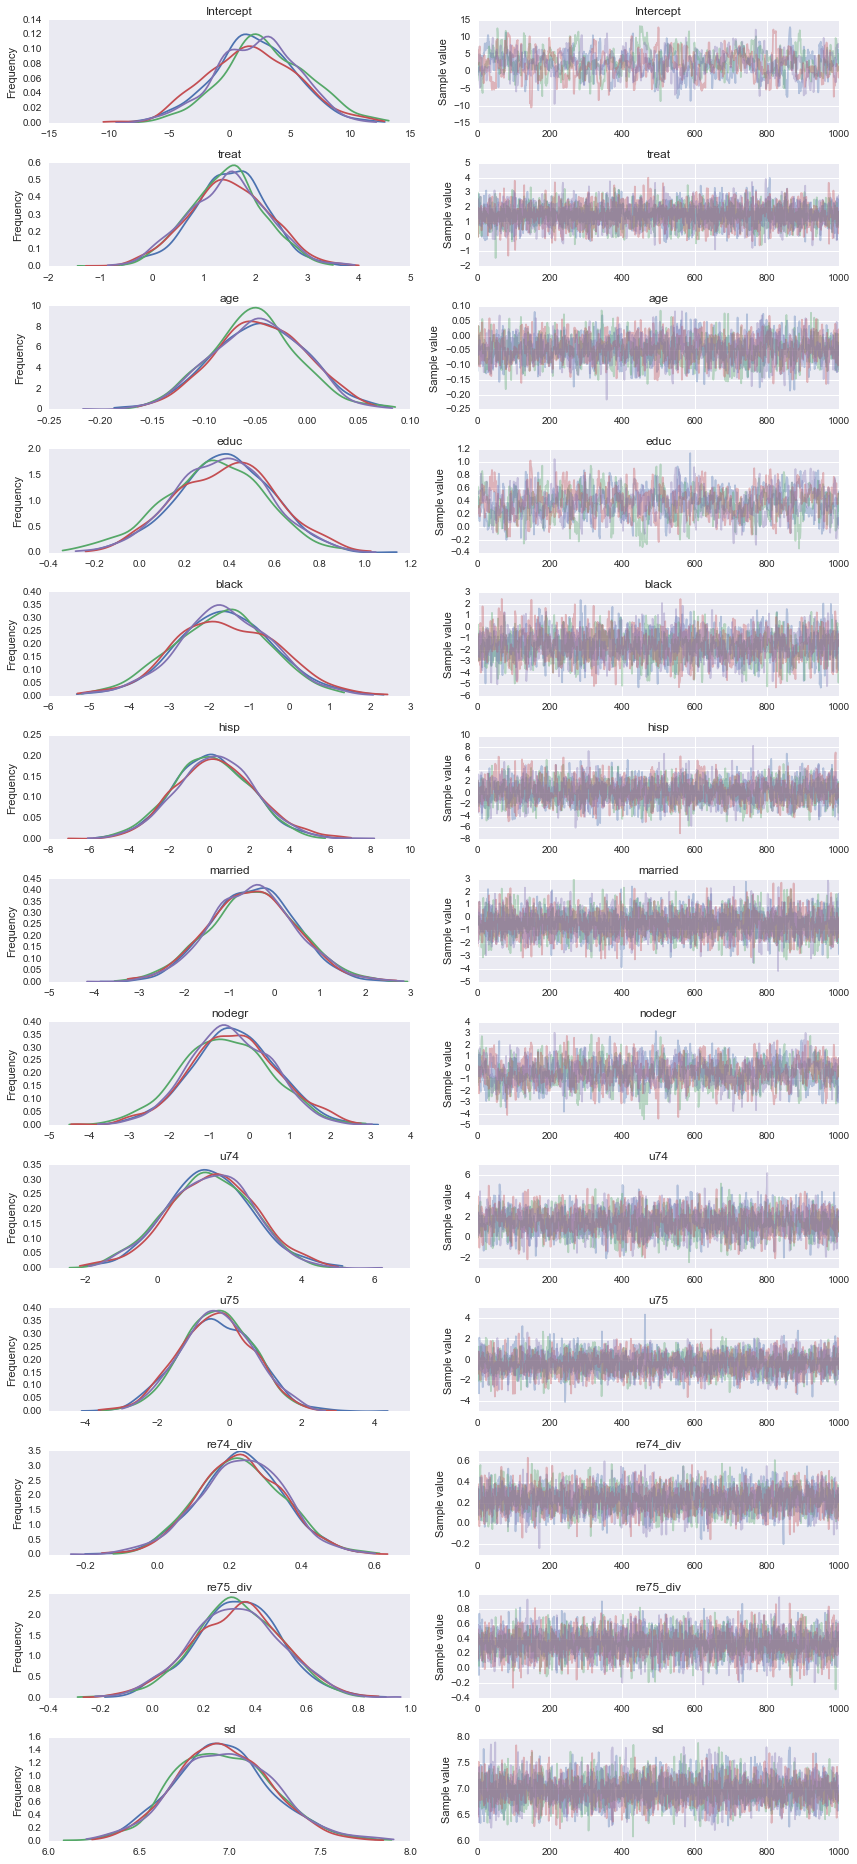

In [167]:
pm.traceplot(mahalanobis_samples[1000:]);

In [164]:
df_mahalanobis_samples = pm.trace_to_dataframe(mahalanobis_samples[1000:])
df_mahalanobis_samples.mean(0)

educ         0.364853
sd           6.969079
age         -0.047519
re74_div     0.230937
u75         -0.349277
hisp         0.224853
black       -1.630488
married     -0.479974
re75_div     0.330659
Intercept    2.299223
treat        1.478219
u74          1.450774
nodegr      -0.460911
dtype: float64

In [165]:
(df_mahalanobis_samples['treat'] > 0).mean()

0.97475000000000001

# Bonus - Estimating the counterfactual observations

Suppose we build two models,

$$
\begin{aligned}
\hat{Y}_1(1) &= \alpha_1 + \beta_1 X_i(1) + \epsilon_i \\
\hat{Y}_0(0) &= \alpha_0 + \beta_0 X_i(0) + \epsilon_i
\end{aligned}
$$

where the coefficients of $\hat{Y}_1$ are learned exclusively on samples of $X$ where we've observed $Y(1)$, and those of $\hat{Y}_2$ are likewise are learned from samples where $Y(0)$.

In [215]:
treatment_propensity = data_propensity_matched[data_propensity_matched.treat == 1]
control_propensity = data_propensity_matched[data_propensity_matched.treat == 0]

In [224]:
formula = 're78_div ~ age + educ + black + hisp + married + nodegr + u74 + u75 + re74_div + re75_div'

In [227]:
treatment_model = smf.glm(formula=formula, data=treatment_propensity).fit()

In [228]:
control_model = smf.glm(formula=formula, data=control_propensity).fit()

Now, looking back at the fundamental problem of causal inference, we want to estimate what the counterfactual outcomes would be, e.g. fill in the gaps.

What if we swap our data and estimate the effect from the two groups using the corresponding models?

$$
\begin{align*}
\hat{Y}_1(0) = \alpha_1 + \beta_1 X_i(0) + \epsilon_i \\
\hat{Y}_0(1) = \alpha_0 + \beta_0 X_i(1) + \epsilon_i
\end{align*}
$$

In [229]:
Y_treatment, X_treatment = dmatrices(causal_formula, treatment_propensity, return_type='dataframe')
Y_control, X_control = dmatrices(causal_formula, control_propensity, return_type='dataframe')

In [230]:
Y_0 = np.expand_dims(treatment_model.predict(exog=X_control), 1)
Y_1 = np.expand_dims(control_model.predict(exog=X_treatment), 1)

Now we can define $\hat{\tau}_i = Y_i - \hat{Y}_1(0)$ for our control group, and $\hat{\tau}_i = \hat{Y}_0(1) - Y_i$ for our treatment group.

We can then calculate average treatment effect as $\hat{\tau} = \frac{1}{N} \sum_{i=1}^N \hat{\tau}_i$.

In [238]:
np.concatenate([
    (Y_treatment - Y_1),    
    (Y_0 - Y_control)        
]).mean()

1.5483643168987633

Why does this work?

# References

- Lalonde, R. J. (1986). Evaluating the Econometric Evaluations of Training Programs with Experimental Data. Journal of Chemical Information and Modeling, 76(4), 604–620. http://doi.org/10.1017/CBO9781107415324.004
- Gelman, a, & Hill, J. (2007). Data analysis using regression and multilevel/hierarchical models. Policy Analysis, 1–651. http://doi.org/10.2277/0521867061
- Imbens, G. W., & Rubin, D. B. (2015). Causal Inference for Statistics, Social, and Biomedical Sciences an Introduction. Cambridge University Press. Retrieved from http://www.cambridge.org/US/academic/subjects/statistics-probability/statistical-theory-and-methods/causal-inference-statistics-social-and-biomedical-sciences-introduction